In [1]:
import tomllib
from pathlib import Path
import numpy as np
from src.modules.loader.data_loader import DataLoader
from src.modules.loader.statspearls_data_loader import StatPearlsDataLoader
from src.modules.loader.medmcqa_data_loader import MedMCQADataLoader
from src.modules.loader.medmcqa_data_loader import format_medmcqa_question
from src.modules.llm.llm_client import LLMClient
from src.modules.rag.rag_engine import RAGEngine
from src.modules.rag.multihop_rag_engine import MultiHopRAGEngine
from src.modules.explainers.shap_explainer import ShapExplainer
from src.modules.explainers.lime_explainer import LimeExplainer

/home/nilspoethkow/Code/Uni/XAI/xai-rag/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Shap

There are no ground truth explanations available for any neural model. We therefore have to use different evaluation metrics.

1. In the Paper "A study on the Interpretability of Neural Retrieval Models using
DeepSHAP" a LIME based explanation was used as proxy (https://github.com/marcotcr/lime)
2. **Faithfullness/Fidelity** We can also use a perturbation based evaluation approach. Meaning we will leave out the as important identified tokens in the query and rerun the retrieval comparing the ranking to each other (AOPC = "Area over perturbation curve"). (https://github.com/CristianCosci/AOPC_MoRF)
3. **Sparseness** Leave out all tokens except the top k identified by DeepSHAP.

${AOPC}_M = \frac{1}{L+1} \left\langle \sum_{k=1}^{L} f(x^{(0)}_M) - f(x^{(k)}_M) \right\rangle_{p(X)}$

### Experiment Setup

Bound by the Computational cost of DeepShap! (Run on KIGS Server?)
1. Select a finite amount of instances from the HotpotQA Dataset.
2. Conduct the Retrieval on those instances.
3. Compute Metrics for every Instance and average them to get overall score for DeepShap Explanability.

It is crucial to select the fitting Background image for SHAP. Fortunately this research was already conducted by [Fernando et. al.](https://arxiv.org/abs/1907.06484). The selection is dependent on the NRM used for the retrieval, tho performances are fairly similar for each NRM.

![Performance Metrics Background Images](img/image.png)

**ATTENTION**: We currently use "sentence-transformers/all-MiniLM-L6-v2" as the embedding model. This is a simple Bi-Encoder and no NRM. A NRM is a Reranker, using both query and document together to generate a relevance score instead of an embedding vector. These models yield significantly better matching results for query and documents, but to the drawback of computational cost and time.

# Implementation

**NOTES:**
- We are looking at only the top document and calculate the AOPC-Metric for only that document. Since it was ranked the highest by the Retriever (no matter if it's a NRM or just Similarity Measure) we can assume that the identified Tokens are relevant for the Query.#
- We can also use LIME for Explanation or Comparison for DeepShap, the implementation is straight forward in fairly similar

### 1. Shap for Bi-Encoder using shap.KernelExplainer (Cosine Similarity)

The **KernelExplainer** is similar to LIME, cause it explains a local instance using the set of locally pertubated instances and fits a linear model on the set. It differs by the way it approximates the values if that model, it uses the approximation of shapely-values, whereas LIME uses a simple exponential kernel.

We use the top Document for the AOPC Metric.

Setup RAG-Engine with LLM-Client.

In [2]:
project_root = next((p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / 'src').exists()), None)

config_path = project_root / "config.toml"
config = {}

if config_path.exists():
    with open(config_path, "rb") as f:
        config = tomllib.load(f)

medmcqa_config = config.get("medmcqa") or {}
rag_config = config.get("rag") or {}
llm_config = config.get("llm") or {}

llm_model = llm_config.get("model")
llm_provider = llm_config.get("provider")

client = LLMClient(provider=llm_provider, model_name=llm_model)

SPLIT = medmcqa_config.get("split", "val")
PERSIST_DIR = project_root / "data" / "vector_db_statpearls"
NUM_HOPS = rag_config.get('n_hops', 2)
NUM_DOCUMENTS = 50

In [3]:
stat_loader = StatPearlsDataLoader(root_dir=str(project_root / "data"))
documents, stats = stat_loader.setup()

rag_engine = RAGEngine(persist_dir=str(PERSIST_DIR))
rag_engine.setup(documents=documents, k=NUM_DOCUMENTS)

multi_hop = MultiHopRAGEngine(rag_engine=rag_engine, llm_client=client, num_hops=NUM_HOPS)

Loading existing vector store from /home/nilspoethkow/Code/Uni/XAI/xai-rag/data/vector_db_statpearls...
RagEngine ready.
Connecting to local Ollama (gemma3:4b)...


Setup med_loader, load the questions and set up the Shap and LIME explainers.

In [4]:
med_loader = MedMCQADataLoader()
questions = med_loader.setup(split=SPLIT, as_documents=False, limit=1)

shap_explainer = ShapExplainer(rag_engine=rag_engine, documents=documents, idf_top_k=100)  # pass documents for IDF calculation
lime_explainer = LimeExplainer(rag_engine=rag_engine)

Loading tokenizer for: sentence-transformers/all-MiniLM-L6-v2
Calculating IDF for 13922 documents...
Background Vocabulary (Lowest IDF): ['patients', 'patient', 'treatment', 'include', 'disease', 'pain', 'used', 'risk', 'use', 'clinical', 'care', 'including', 'associated', 'multiple', 'therapy', 'common', '10', 'medical', 'team', 'high', 'diagnosis', 'management', 'chronic', 'outcomes', 'healthcare', 'cases', 'imaging', 'following', 'studies', 'symptoms', 'increased', 'physical', 'using', 'evaluation', 'significant', 'cause', 'based', 'factors', 'access', 'blood', 'free', 'complications', 'drug', 'time', 'muscle', 'low', 'activity', 'specific', 'history', '12', 'normal', 'present', 'surgical', 'choice', 'usually', 'review', 'health', 'tissue', 'potential', 'surgery', '15', 'questions', 'severe', 'interprofessional', 'non', 'typically', 'performed', 'function', 'role', 'appropriate', 'effects', 'nerve', 'related', 'results', 'education', 'body', 'study', 'commonly', 'topic', '20', 'esse

In [5]:
questions

[{'question': '30 yr old mom presents with cramping gluteal pain after walking 500Mt which is the vessel involved ?',
  'exp': 'Aerial do with aoo iliac involvement, LERCHE&;s SYNDROME patient presents with gluteal claudication and impotence ref : bailey and love 27th ed',
  'cop': 1,
  'opa': 'Aerial disease with aoa iliac involvement',
  'opb': 'Varicose vein',
  'opc': 'Aerial disease with femoral aery involvement',
  'opd': 'Femoral venous insufficiency',
  'subject_name': 'Surgery',
  'topic_name': 'All India exam',
  'id': '5288e33d-a4df-4fd8-8498-7b0030b6fbc3',
  'choice_type': 'single'}]

Setup and run Multi-Hop Retrieval experiment. For this we will select a random set of questions from the dataset.

In [6]:
results = []
for item in questions:
    question_text = format_medmcqa_question(item)
    if not question_text:
        continue

    trace, _ = multi_hop.run_and_trace(question_text)
    final_answer = (trace.get("final_answer") or "").strip()

    results.append(
        {
            "question": question_text,
            "final_answer": final_answer,
            "trace": trace
        }
    )

--- Starting Multi-Hop Search for: 'Which of the following agents is likely to cause cerebral calcification and hydrocephalus in a newborn whose mother has history of taking spiramycin but was not compliant with therapy?

Options:
A: Rubella
B: Toxoplasmosis
C: CMV
D: Herpes' ---

[ Hop 1 ]
Executing search with query: 'Which of the following agents is likely to cause cerebral calcification and hydrocephalus in a newborn whose mother has history of taking spiramycin but was not compliant with therapy?

Options:
A: Rubella
B: Toxoplasmosis
C: CMV
D: Herpes'
Generating next query...

[ Hop 2 ]
Executing search with query: '"intracranial calcifications pathogenesis CMV"'

Generating final answer...

--- Multi-Hop Search Complete. Final Answer: CMV is the most common congenital infection. It will present with intrauterine growth restriction and low birth weight, hepatosplenomegaly, jaundice, paraventricular calcifications, cataracts, and sensorineural hearing loss and bone marrow suppressi

## 2. Shap Explanations

We can select a Key for which Document to explain:
1. "highest_ranked_document"
2. "lowest_ranked_document"
3. "context_documents": Also pass the rank of the target document as index (< NUM_DOCUMENTS)

In [7]:
shap_explanation = shap_explainer.explain(results[0]["trace"], explained_doc_key="lowest_ranked_document", background="Low-IDF")
lime_explanation = lime_explainer.explain(results[0]["trace"], explained_doc_key="lowest_ranked_document")

--- Shap Explaining Hop 1 (Background: Low-IDF) ---
--- Shap Explaining Hop 2 (Background: Low-IDF) ---
--- LIME Explaining Hop 1 ---
--- LIME Explaining Hop 2 ---


For Shap we will investigate different strategies (also mentioned in the paper) for the background image:
1. Zero Embeddings indicating missing values
2. Average Token Embeddings across the Document (even better would be across the entirety of documents)
3. IDF (lowest) -> For this we will create a dataset of Low IDF from a representative sample of all documents (during \_\_init\_\_)

Query: "intracranial calcifications pathogenesis CMV"
Score: 0.3775


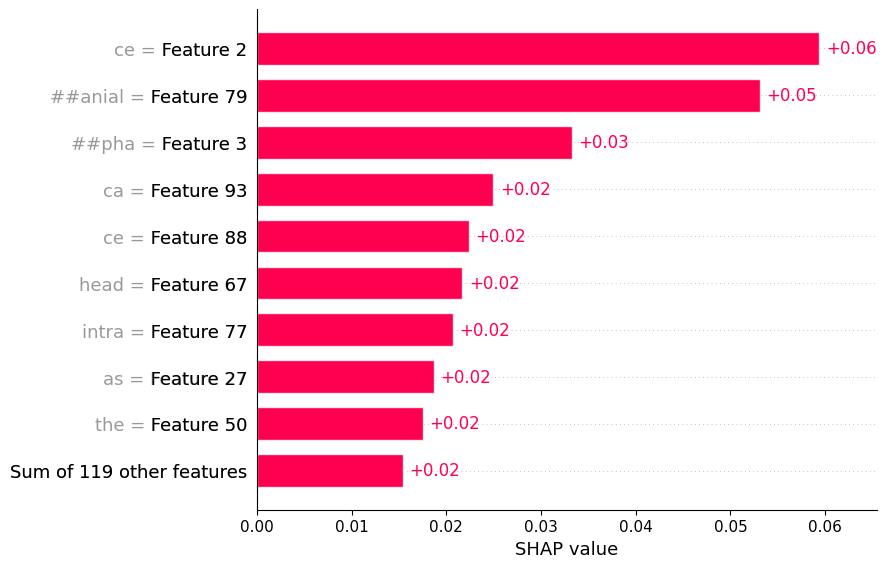

In [11]:
shap_explainer.plot_bar(shap_explanation, "hop_2")
shap_explainer.plot_text_heatmap(shap_explanation, "hop_2")

Because all Documents in the Database are part of a medical terminology, it's unlikely to find tokens with shap, that negatively impact the cosine similarity. This would more likely be found in a ColBert based RAG-System.

## 2. Lime Explanations

Molnar, LIME for text data.

IDF does not work for LIME, cause it uses the hard coded deletion of strings when perturbating.

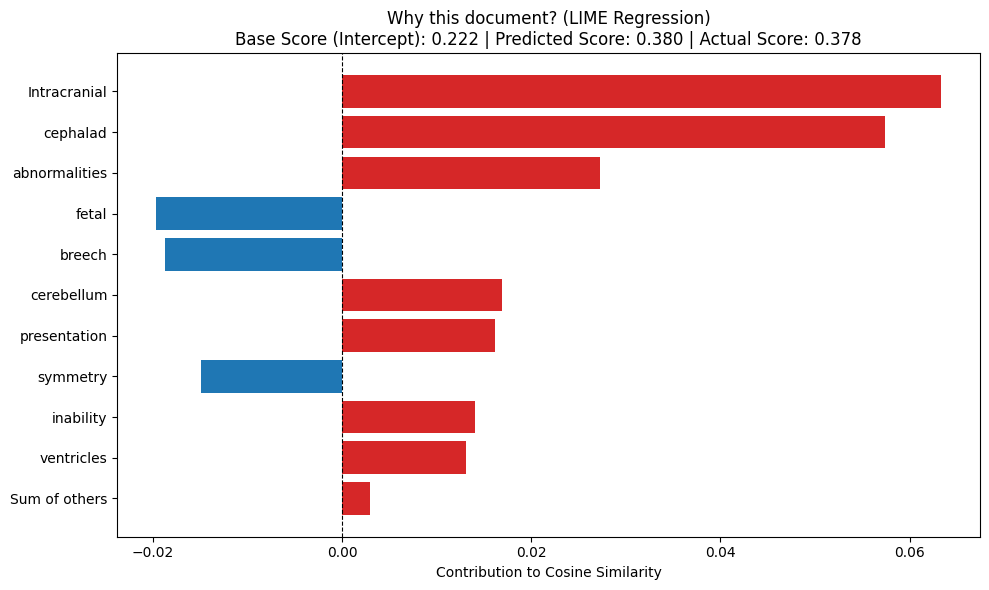

In [12]:
# Pass the WHOLE dictionary for the hop, not just ["explanation_tuples"]
lime_explainer.plot_bar(explanation_data=lime_explanation["hop_2"])
lime_explainer.plot_text_heatmap(explanation_data=lime_explanation["hop_2"])